<a href="https://colab.research.google.com/github/bkrant/DS-Unit-2-Sprint-3-Classification-Validation/blob/master/module2-baselines-validation/LS_DS_232_Baselines_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Classification & Validation_ 

# Baselines & Validation

Objectives
- Train/Validate/Test split
- Cross-Validation
- Begin with baselines

## Weather data —  mean baseline

Let's try baselines for regression.

You can [get Past Weather by Zip Code from Climate.gov](https://www.climate.gov/maps-data/dataset/past-weather-zip-code-data-table). I downloaded the data for my town: Normal, Illinois.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 

url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-3-Classification-Validation/master/module2-baselines-validation/weather-normal-il.csv'
weather = pd.read_csv(url, parse_dates=['DATE']).set_index('DATE')
weather['2014-05':'2019-05'].plot(y='TMAX')
plt.title('Daily high temperature in Normal, IL');

Over the years, across the seasons, the average daily high temperature in my town is about 63 degrees.

In [0]:
weather['TMAX'].mean()

Remember from [the preread:](https://github.com/LambdaSchool/DS-Unit-2-Sprint-3-Classification-Validation/blob/master/module2-baselines-validation/model-validation-preread.md#what-does-baseline-mean) "A baseline for regression can be the mean of the training labels."

If I predicted that every day, the high will be 63 degrees, I'd be off by about 19 degrees on average.

In [0]:
from sklearn.metrics import mean_absolute_error
predicted = [weather['TMAX'].mean()] * len(weather)  
mean_absolute_error(weather['TMAX'], predicted)

But, we can get a better baseline here: "A baseline for time-series regressions can be the value from the previous timestep."

*Data Science for Business* explains, 

> Weather forecasters have two simple—but not simplistic—baseline models that they compare against. ***One (persistence) predicts that the weather tomorrow is going to be whatever it was today.*** The other (climatology) predicts whatever the average historical weather has been on this day from prior years. Each model performs considerably better than random guessing, and both are so easy to compute that they make natural baselines of comparison. Any new, more complex model must beat these.

Let's predict that the weather tomorrow is going to be whatever it was today. Which is another way of saying that the weather today is going to be whatever it was yesterday.

We can engineer this feature with one line of code, using the pandas [`shift`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html) function.

This new baseline is off by less than 6 degress on average.

In [0]:
weather['TMAX_yesterday'] = weather.TMAX.shift(1)
weather = weather.dropna()  # Drops the first date, because it doesn't have a "yesterday"
mean_absolute_error(weather.TMAX, weather.TMAX_yesterday)

I applied this same concept for [my first submission to the Kaggle Instacart competition.](https://github.com/rrherr/springboard/blob/master/Kaggle%20Instacart%20first%20submission.ipynb)

## Bank Marketing — majority class baseline

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

>The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

>Output variable (desired target):  
>y - has the client subscribed a term deposit? (binary: 'yes','no')

>bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010)

Get and read the data

In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

In [0]:
!unzip bank-additional.zip

In [0]:
bank = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

Assign to X and y

In [0]:
X = bank.drop(columns='y')
y = bank['y'] == 'yes'

## 3-way split: Train / Validation / Test 

We know how to do a _two-way split_, with the [**`sklearn.model_selection.train_test_split`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function:

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

How can we get from a two-way split, to a three-way split?

We can use the same function again, to split the training data into training and validation data.

In [0]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [0]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

## Majority class baseline

Determine the majority class:

What if we guessed the majority class for every prediction?

#### [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Baseline accuracy by guessing the majority class for every prediction:

#### [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

Baseline "ROC AUC" score by guessing the majority class for every prediction:

## Fast first models

### Ignore rows/columns with nulls

Does this dataset have nulls?

### Ignore nonnumeric features

Here are the numeric features:

Here are the nonnumeric features:

Just select the nonnumeric features:

In [0]:
X_train_numeric = X_train.select_dtypes('number')
X_val_numeric = X_val.select_dtypes('number')

### Shallow trees are good for fast, first baselines, and to look for "leakage"

#### Shallow trees

After naive baselines, *Data Science for Business* suggests ["decision stumps."](https://en.wikipedia.org/wiki/Decision_stump)

> A slightly more complex alternative is a model that only considers a very small amount of feature information. ...

> One example is to build a "decision stump"—a decision tree with only one internal node, the root node. A tree limited to one internal node simply means that the tree induction selects the single most informative feature to make a decision. In a well-known paper in machine learning, [Robert Holte (1993)](https://link.springer.com/article/10.1023/A:1022631118932) showed that ***decision stumps often produce quite good baseline performance*** ...

> A decision stump is an example of the strategy of ***choosing the single most informative piece of information*** available and basing all decisions on it. In some cases most of the leverage may be coming from a single feature, and this method assesses whether and to what extent this is the case.

To fit a "decision stump" we could use a [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) model with parameter `max_depth=1`.

In this case, we'll let our tree grow a little deeper, and use the parameter `max_depth=2`

In the previous code cell, we selected only the numeric features, to avoid data wrangling and save time. For now, we'll use only the numeric features.

#### Looking for leakage

[Xavier Amatriain recommends,](https://www.quora.com/What-are-some-best-practices-for-training-machine-learning-models/answer/Xavier-Amatriain)

"Make sure your training features do not contain data from the “future” (aka time traveling). While this might be easy and obvious in some cases, it can get tricky. ... If your test metric becomes really good all of the sudden, ask yourself what you might be doing wrong. Chances are you are time travelling or overfitting in some way."

We can test this with the [UCI repository's Bank Marketing dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). It has a feature which leaks information from the future and should be dropped:

>11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input ... should be discarded if the intention is to have a realistic predictive model.

#### Let's train a shallow tree basline

... without dropping the leaky `duration` feature.

Then we can visualize the tree to see which feature(s) were the "most informative":

In [0]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None, feature_names=X_train_numeric.columns, 
                           class_names=['No', 'Yes'], filled=True, impurity=False, proportion=True)

graphviz.Source(dot_data)

This baseline has a ROC AUC score above 0.85, and it uses the `duration` feature, as well as `nr.employed`, a "social and economic context attribute" for "number of employees - quarterly indicator."

#### Let's drop the  `duration` feature

When the `duration` feature is dropped, then the ROC AUC score drops. Which is what we expect, it's not a bad thing in this situation!

In [0]:
dot_data = export_graphviz(tree, out_file=None, feature_names=X_train_numeric.columns, 
                           class_names=['No', 'Yes'], filled=True, impurity=False, proportion=True)

graphviz.Source(dot_data)

### Logistic Regression

Logistic Regression is another great option for fast, first baselines!

### With Scaler
https://scikit-learn.org/stable/modules/preprocessing.html

In [0]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

### Same, as a pipeline

### Encode "low cardinality" categoricals

[Cardinality](https://simple.wikipedia.org/wiki/Cardinality) means the number of unique values that a feature has:
> In mathematics, the cardinality of a set means the number of its elements. For example, the set A = {2, 4, 6} contains 3 elements, and therefore A has a cardinality of 3. 

One-hot encoding adds a dimension for each unique value of each categorical feature. So, it may not be a good choice for "high cardinality" categoricals that have dozens, hundreds, or thousands of unique values. 

In this dataset, all the categoricals seem to be "low cardinality", so we can use one-hot encoding.

#### Install the [Category Encoders](https://github.com/scikit-learn-contrib/categorical-encoding) library

If you're running on Google Colab:

```
!pip install category_encoders
```

If you're running locally with Anaconda:

```
!conda install -c conda-forge category_encoders
```

# Baseline with cross-validation + independent test set
A complete example, as an alternative to Train/Validate/Test


#### scikit-learn documentation
- [`sklearn.model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
- [ The `scoring` parameter: defining model evaluation rules](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)

In [0]:
# Imports
%matplotlib inline
import warnings
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Load data
bank = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

# Assign to X, y
X = bank.drop(columns='y')
y = bank['y'] == 'yes'

# Drop leaky & random features
X = X.drop(columns='duration')

# Split Train, Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

# Cross-validate with training data
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1, verbose=10)

This is the baseline score that more sophisticated models must beat. 

In [0]:
print('Cross-Validation ROC AUC scores:', scores)
print('Average:', scores.mean())

Is more effort justified? It depends. The blogpost ["Always start with a stupid model"](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa) explains,

> Here is a very common story: a team wants to implement a model to predict something like the probability of a user clicking an ad. They start with a logistic regression and quickly (after some minor tuning) reach 90% accuracy.

> From there, the question is: Should the team focus on getting the accuracy up to 95%, or should they solve other problems 90% of the way?

> ***If a baseline does well, then you’ve saved yourself the headache of setting up a more complex model. If it does poorly, the kind of mistakes it makes are very instructive*** ...

So what else can we learn from this baseline? 

["Always start with a stupid model"](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa) suggests to look at

> **What type of signal your model picks up on.** Most baselines will allow you to extract ***feature importances***, revealing which aspects of the input are most predictive. Analyzing feature importance is a great way to realize how your model is making decisions, and what it might be missing.

We can do that:

In [0]:
# (Re)fit on training data
pipeline.fit(X_train, y_train)

# Visualize coefficients
plt.figure(figsize=(10,30))
plt.title('Coefficients')
coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = pipeline.named_steps['onehotencoder'].transform(X_train).columns
pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');

[The post](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa) also recommends we consider, 

> **What signal your model is missing.** If there is a certain aspect of the data that seems intuitively important but that your model is ignoring, ***a good next step is to engineer a feature*** or pick a different model that could better leverage this particular aspect of your data.

### Look at your data (you still need to do it!)

Cautionary tales
- [Exploring the ChestXray14 dataset: problems](https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/)
- [The Quartz guide to bad data](https://github.com/Quartz/bad-data-guide)

Incomplete list of issues to address
- Categoricals (text, dates/times, high cardinality)
- Feature Engineering (extraction, interaction, transformations)
- Missing Values
- Outliers

# ASSIGNMENT options

- **Replicate the lesson code.** [Do it "the hard way" or with the "Benjamin Franklin method."](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit)
- Apply the lesson to other datasets you've worked with before, and compare results.
- Iterate and improve your **Bank Marketing** model. Engineer new features.
- Get **weather** data for your own area and calculate both baselines.  _"One (persistence) predicts that the weather tomorrow is going to be whatever it was today. The other (climatology) predicts whatever the average historical weather has been on this day from prior years."_ What is the mean absolute error for each baseline? What if you average the two together? 
- [This example from scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html) demonstrates its improved `OneHotEncoder` and new `ColumnTransformer` objects, which can replace functionality from [third-party libraries](https://github.com/scikit-learn-contrib) like category_encoders and sklearn-pandas. Adapt this example, which uses Titanic data, to work with Bank Marketing or another dataset.
- When would this notebook's pipelines fail? How could you fix them? Add more [preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) and [imputation](https://scikit-learn.org/stable/modules/impute.html) to your [pipelines](https://scikit-learn.org/stable/modules/compose.html) with scikit-learn.

In [3]:
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data')
df.sample(2)

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
97,phon_R01_S24_1,125.036,143.946,116.187,0.01280,0.00010,0.00743,0.00623,0.02228,0.03886,0.342,0.02135,0.02174,0.03088,0.06406,0.08151,15.338,1,0.629574,0.714485,-4.020042,0.265315,2.671825,0.340623
182,phon_R01_S44_6,149.818,163.417,144.786,0.00336,0.00002,0.00174,0.00198,0.00521,0.02145,0.198,0.01155,0.01341,0.01666,0.03464,0.00595,23.008,1,0.329577,0.757180,-6.277170,0.109397,2.209021,0.156368


In [4]:
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

In [6]:
df.dtypes

name                 object
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
status                int64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
dtype: object

In [7]:
df.status.value_counts(normalize=True) # 1 = Parkinson's   0 = healthy

1    0.753846
0    0.246154
Name: status, dtype: float64

In [13]:
df.shape

(195, 24)

In [0]:
X = df.drop(columns=['status', 'name'])
y = df['status']

In [20]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,0.015664,0.017878,0.024081,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,0.010153,0.012024,0.016947,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,0.004550,0.005700,0.007190,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,0.008245,0.009580,0.013080,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,0.012790,0.013470,0.018260,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,0.020265,0.022380,0.029400,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,0.056470,0.079400,0.137780,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [19]:
X.columns

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'],
      dtype='object')

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0250s.) Setting batch_size=256.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0250s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [28]:
scores

array([0.875     , 0.83333333, 0.9375    , 0.97916667, 0.77083333,
       0.89583333, 0.95833333, 0.8125    , 1.        , 1.        ])

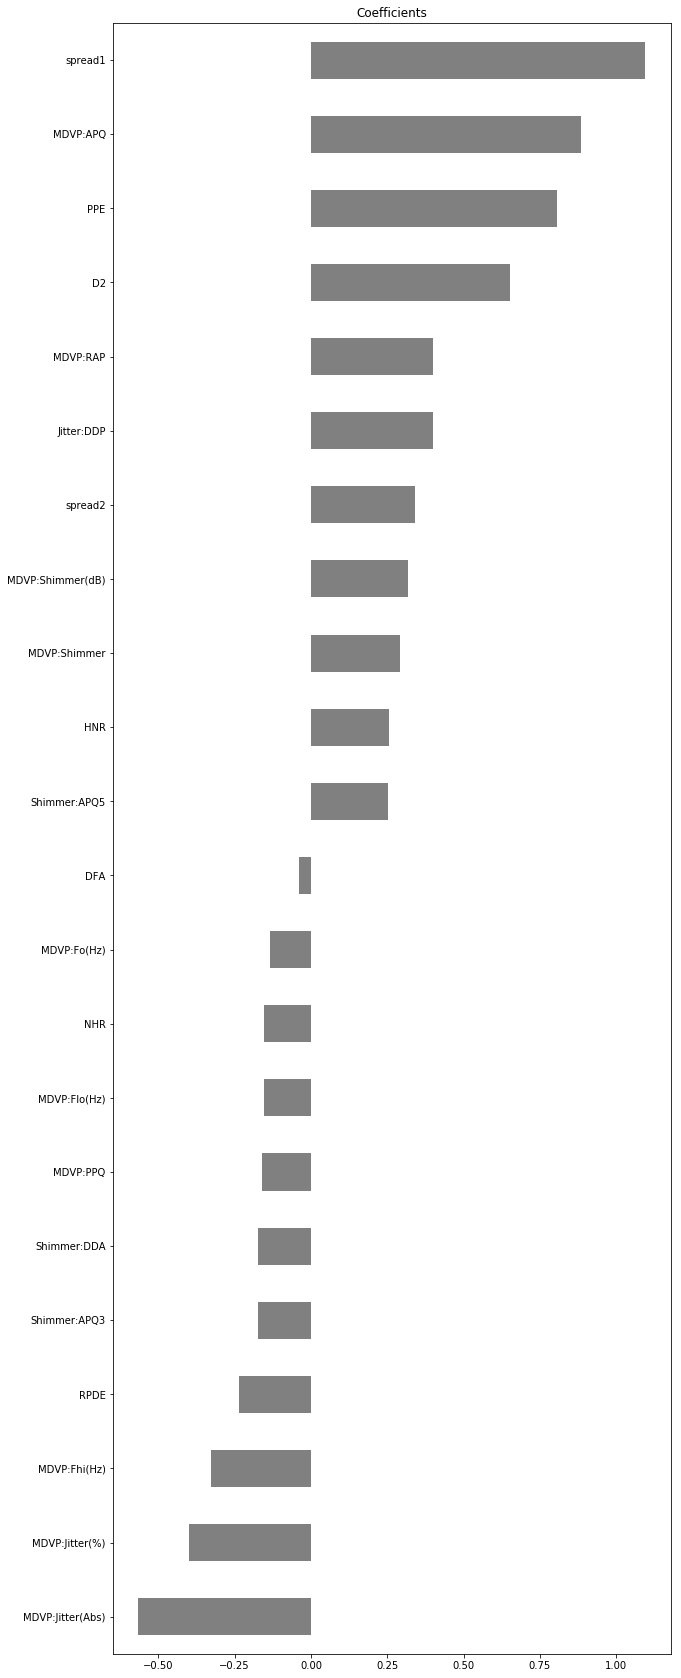

In [31]:
# (Re)fit on training data
import matplotlib.pyplot as plt
pipeline.fit(X_train, y_train)

# Visualize coefficients
plt.figure(figsize=(10,30))
plt.title('Coefficients')
coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = X.columns.tolist()#pipeline.named_steps['onehotencoder'].transform(X_train).columns
pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');